<a href="https://colab.research.google.com/github/mkmritunjay/machineLearning/blob/master/DTClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Decision Tree

We will be using same dataset that we used for logistic regression. 

**Goal or objective:**

We will try to predict if a customer is bad when he applies for a loan. It's also called as probability of default (PD).

In [56]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.formula.api as sm
import scipy.stats as stats

%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 7.5
plt.rcParams['axes.grid'] = True
plt.gray()

from matplotlib.backends.backend_pdf import PdfPages

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

import sklearn.tree as dt
import sklearn.ensemble as en

from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier, export_graphviz, export
from sklearn.model_selection import GridSearchCV

import pydotplus as pdot
from IPython.display import Image

url = 'https://raw.githubusercontent.com/mkmritunjay/machineLearning/master/bankloans.csv'

<Figure size 720x540 with 0 Axes>

In [57]:
bankloan_df = pd.read_csv(url)
bankloan_df.head()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,41,3,17,12,176,9.3,11.359392,5.008608,1.0
1,27,1,10,6,31,17.3,1.362202,4.000798,0.0
2,40,1,15,14,55,5.5,0.856075,2.168925,0.0
3,41,1,15,14,120,2.9,2.658720,0.821280,0.0
4,24,2,2,0,28,17.3,1.787436,3.056564,1.0


In [0]:
bankloans_existing = bankloan_df[bankloan_df.default.isnull()==0]
bankloans_new = bankloan_df[bankloan_df.default.isnull()==1]

In [0]:
X = bankloans_existing

In [60]:
X.columns

Index(['age', 'ed', 'employ', 'address', 'income', 'debtinc', 'creddebt',
       'othdebt', 'default'],
      dtype='object')

In [61]:
features = X.columns.difference(['default'])
features

Index(['address', 'age', 'creddebt', 'debtinc', 'ed', 'employ', 'income',
       'othdebt'],
      dtype='object')

### Train Test Split

In [0]:
train_X, test_X, train_y, test_y = train_test_split( X[features],
                                                  X['default'],
                                                  test_size = 0.3,
                                                  random_state = 142 )

In [63]:
clf_tree = DecisionTreeClassifier(max_depth=3)
clf_tree.fit(train_X, train_y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [0]:
train_y.index = pd.DataFrame(clf_tree.predict_proba( train_X )).index

In [0]:
tree_train_pred_prob = pd.concat([ pd.DataFrame(clf_tree.predict_proba( train_X )), train_y], axis=1, ignore_index=True)

In [0]:
tree_train_pred_prob.columns = ['pred_prob_0', 'pred_prob_1', 'actual']

In [67]:
tree_train_pred_prob.head(15)

,pred_prob_0,pred_prob_1,actual
0,0.896552,0.103448,1.0
1,0.928870,0.071130,0.0
2,0.928870,0.071130,0.0
3,0.928870,0.071130,0.0
4,0.678161,0.321839,0.0
5,0.323529,0.676471,1.0
6,0.928870,0.071130,0.0
7,0.928870,0.071130,0.0
8,0.928870,0.071130,0.0
9,0.928870,0.071130,0.0


In [68]:
tree_train_pred_prob["actual"].astype('object')

0      1
1      0
2      0
3      0
4      0
      ..
485    0
486    0
487    0
488    0
489    0
Name: actual, Length: 490, dtype: object

In [69]:
metrics.roc_auc_score(tree_train_pred_prob["actual"], tree_train_pred_prob["pred_prob_1"])

0.8346165884194054

In [0]:
# By default predict() takes cut-off as 0.5
# when we have equal distribution of 0's and 1's this approach makes sense. But in case of unequal distribution we need to convert
# imbalanced data into balanced data. We can use SMOTE (oversampling or undersampling method) to convert imbalanced data into balanced data.
tree_train_pred = pd.DataFrame( { 'actual':  train_y,
                            'pred': clf_tree.predict( train_X )} )

tree_test_pred = pd.DataFrame( { 'actual':  test_y,
                            'pred': clf_tree.predict( test_X ) } )

In [71]:
metrics.accuracy_score( tree_train_pred.actual, tree_train_pred.pred)

0.8081632653061225

In [72]:
metrics.accuracy_score( tree_test_pred.actual, tree_test_pred.pred )

0.7666666666666667

## Confusion matrix

Text(0.5, 46.5, 'Predicted label')

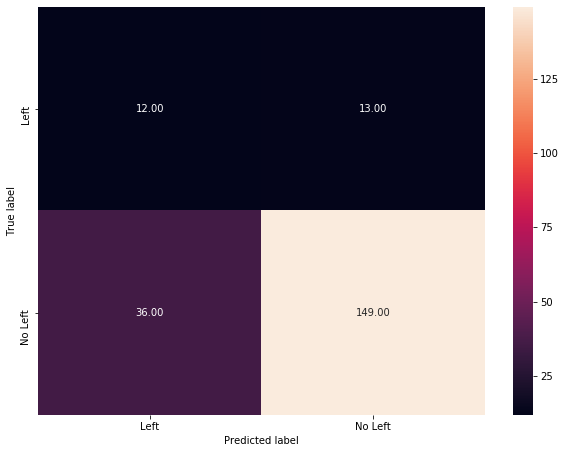

In [73]:
tree_cm = metrics.confusion_matrix( tree_test_pred.pred,
                                 tree_test_pred.actual,
                                 [1,0] )
sns.heatmap(tree_cm, annot=True, fmt='.2f',
         xticklabels = ["Left", "No Left"] , yticklabels = ["Left", "No Left"] )

plt.ylabel('True label')
plt.xlabel('Predicted label')

In [74]:
tree_cm

array([[ 12,  13],
       [ 36, 149]])

## Fine tuning the parameter

In [0]:
param_grid = {'max_depth': np.arange(3, 8), 'max_features': np.arange(2,8)}

In [76]:
tree = GridSearchCV(DecisionTreeClassifier(), param_grid, cv = 5)
tree.fit( train_X, train_y )

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': array([3, 4, 5, 6, 7]),
                

In [77]:
tree.best_params_

{'max_depth': 3, 'max_features': 4}

In [78]:
tree.best_score_

0.7755102040816327

## Building final Model

Using above best parameters (depth=3, features=5) we will build our final model.

In [79]:
clf_tree_final = DecisionTreeClassifier( max_depth = 3, max_features=5)
clf_tree_final.fit( train_X, train_y )

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [0]:
tree_test_pred = pd.DataFrame({'actual':test_y, 'predicted':clf_tree_final.predict(test_X)})

In [81]:
metrics.accuracy_score( tree_test_pred.actual, tree_test_pred.predicted )

0.7571428571428571

Text(0.5, 46.5, 'Predicted label')

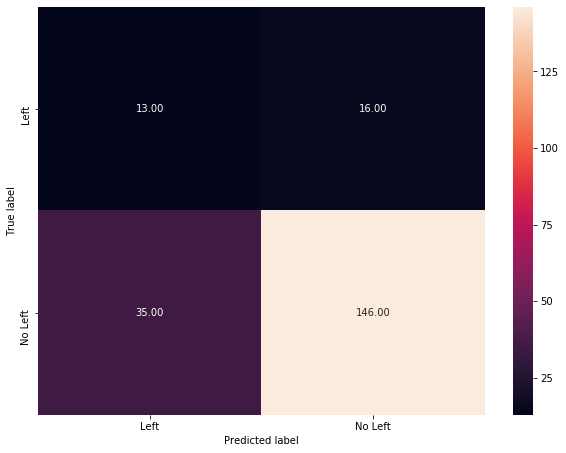

In [82]:
tree_cm = metrics.confusion_matrix( tree_test_pred.predicted,
                                 tree_test_pred.actual,
                                 [1,0] )
sns.heatmap(tree_cm, annot=True,
         fmt='.2f',
         xticklabels = ["Left", "No Left"] , yticklabels = ["Left", "No Left"] )

plt.ylabel('True label')
plt.xlabel('Predicted label')

In [0]:
export_graphviz(clf_tree_final, out_file='tree.odt',feature_names=train_X.columns)

In [84]:
tree_graph = pdot.graphviz.graph_from_dot_file('tree.odt')
tree_graph.write_jpg( 'tree.jpg' )

True

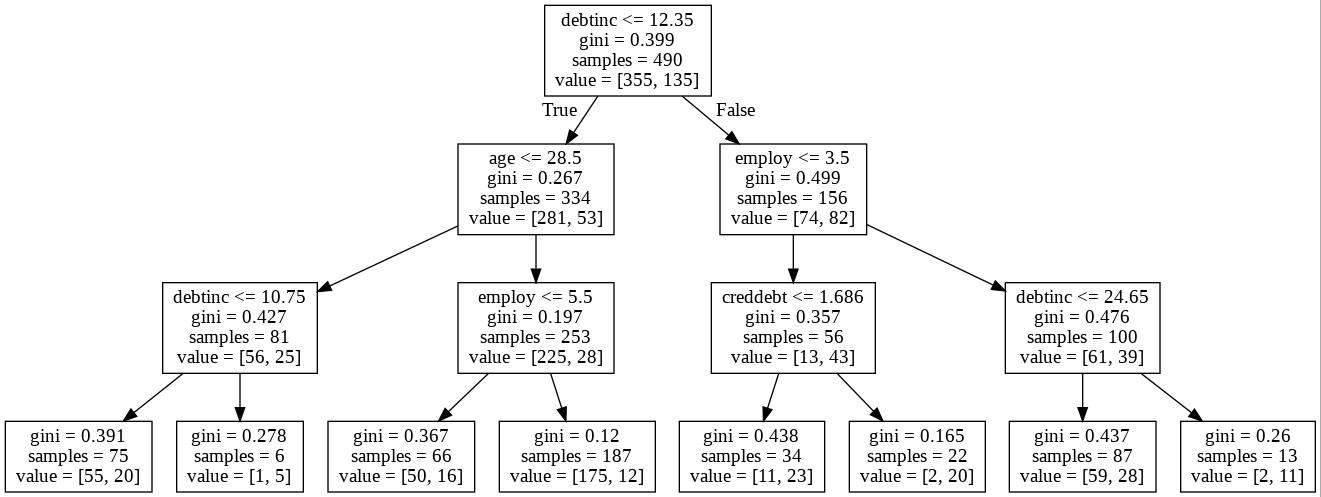

In [85]:
Image(filename='tree.jpg')